# Two Sigma News Exploratory Data Analysis
### By: Zihan

### Requirements

In order to run this file, you must have downloaded both datasets into the project root directory. Don't worry about accidentally uploading files to master because `.gitignore` is already handling that.

## Step 1: Data Curation

+ `wget kaggle_user_data_link` with a little bit of hacking (found the downloadable route in chrome browser)
+ the above won't work in usual way because of the network interruption issues (applicable only to large file)
+ uploaded data to dropbox to share with teammate
+ able to load data directly into working space (my playground)

In [1]:
import pandas as pd
import warnings; warnings.simplefilter('ignore')
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go
from datetime import datetime
import sys
from wordcloud import WordCloud

In [2]:
news_train_dir = "./new_train_df.csv"
news_train_df = pd.read_csv(news_train_dir)

In [3]:
news_train_df.shape

(9328750, 36)

In [4]:
market_train_dir = "./market_train_df.csv"
market_train_df = pd.read_csv(market_train_dir)

In [5]:
market_train_df.shape

(4072956, 17)

In [6]:
news_train_df.shape

(9328750, 36)

## Step 2: EDA

+ visualize random stock
+ outliers checking
+ visualize word cloud

### 2.1 Visualize Random Stock's Closing Price

Randomly select 10 assets and plot the closing price for each.

In [7]:
data = []
for asset in np.random.choice(market_train_df['assetName'].unique(), 10):
    asset_df = market_train_df[(market_train_df['assetName'] == asset)]
    asset_df["time"] = pd.to_datetime(asset_df['time'], errors='coerce')
    data.append(go.Scatter(
        x = asset_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = asset_df['close'].values,
        name = asset))
layout = go.Layout(dict(title = "10 Random Asset: Closing Price Time Series",
                  xaxis = dict(title = ''),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

### 2.1 Conclusion:

Be careful with survival bias here. 

+ Some stocks became into existence after the earlier datetime
+ some companies went bankrupt or got acquired in the middle

Therefore, we need to handle each stock's life span properly

### 2.2 Outliers

Garbage In, Garbage Out. Let's check if there are corrupted rows. 

In [8]:
market_train_df['price_diff'] = market_train_df['close'] - market_train_df['open']
grouped = market_train_df.groupby('time').agg({'price_diff': ['std', 'min']}).reset_index()
g = grouped.sort_values(('price_diff', 'std'), ascending=False)[:10]
g

time  price_diff           
                                        std        min
736   2010-01-04 22:00:00+00:00  256.120931 -9948.9900
418   2008-09-29 22:00:00+00:00   81.761803 -3261.6136
338   2008-06-05 22:00:00+00:00   25.375271  -982.7000
317   2008-05-06 22:00:00+00:00   23.955264  -938.9500
165   2007-09-27 22:00:00+00:00   23.836764  -920.0000
2373  2016-07-06 22:00:00+00:00    6.402837   -49.3400
2043  2015-03-16 22:00:00+00:00    5.147030  -207.2100
34    2007-03-22 22:00:00+00:00    3.522257    -4.6100
91    2007-06-13 22:00:00+00:00    3.034322   -14.1700
5     2007-02-08 22:00:00+00:00    2.990822  -110.4800

Even Bitcin does not have a `9948` dollar drop in a day. Therefore, we know these data is corrupted. Let's check several manually.

In [9]:
market_train_df.sort_values('price_diff')[:10]

,Unnamed: 0,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe,price_diff
1127598,1127598,2010-01-04 22:00:00+00:00,TW.N,Towers Watson & Co,223136.0,50.00,9998.9900,-0.058470,185.988360,-0.056911,163.671298,-0.024316,189.918708,0.034162,188.184866,13.167586,0.0,-9948.9900
627547,627547,2008-09-29 22:00:00+00:00,BK.N,Bank of New York Mellon Corp,18718479.0,26.50,3288.1136,-0.271578,99.125262,-0.064067,98.933405,-0.275164,84.405548,-0.189620,83.371024,4.061628,1.0,-3261.6136
502997,502997,2008-06-05 22:00:00+00:00,AHG.N,Apria Healthcare Group Inc,801892.0,17.29,999.9900,0.009930,58.523214,-0.001831,58.449248,0.104792,62.410907,0.140881,54.556118,-4.176442,0.0,-982.7000
471381,471381,2008-05-06 22:00:00+00:00,CEPH.O,Cephalon Inc,4846.0,61.04,999.9900,0.014628,15.547907,0.009554,14.982480,-0.039950,14.742916,-0.053743,14.824286,0.087719,1.0,-938.9500
242847,242847,2007-09-27 22:00:00+00:00,EXH.N,Archrock Inc,490100.0,79.99,999.9900,0.022236,11.658101,0.018789,11.570153,0.007304,11.618170,0.012866,552.522473,-0.550395,1.0,-920.0000
3264631,3264631,2015-03-16 22:00:00+00:00,TECD.O,Tech Data Corp,674385.0,56.59,263.8000,0.036447,3.868057,0.020318,3.781770,-0.066172,3.442573,-0.021922,3.284477,0.072616,0.0,-207.2100
7273,7273,2007-02-08 22:00:00+00:00,BA.N,Boeing Co,5155700.0,89.52,200.0000,-0.009186,1.207749,-0.006835,1.202170,0.043010,1.299798,NaN,NaN,0.004434,1.0,-110.4800
375899,375899,2008-02-06 22:00:00+00:00,CME.N,CME Group Inc,8676040.0,485.25,583.4900,-0.175866,-0.061536,-0.165490,-0.023137,-0.204495,0.025448,-0.188712,-0.021896,-0.006932,1.0,-98.2400
628075,628075,2008-09-29 22:00:00+00:00,IBM.N,International Business Machines Corp,9586679.0,114.46,191.9800,-0.041534,0.637915,0.018300,0.634691,-0.006337,0.664182,0.010630,0.666148,0.013094,1.0,-77.5200
3565205,3565205,2015-11-20 22:00:00+00:00,CMG.N,Chipotle Mexican Grill Inc,5023617.0,536.19,612.0000,-0.123171,0.027863,-0.123970,0.028139,-0.124445,0.004926,NaN,NaN,-0.001849,0.0,-75.8100


We know the data is not cleaned, so we need to clean it by std instead of pure price diff.

In [10]:
market_train_df['close_to_open'] =  np.abs(market_train_df['close'] / market_train_df['open'])

In [11]:
market_train_df['close_to_open'].head(3)

0    1.000622
1    1.003610
2    0.987365
Name: close_to_open, dtype: float64

In [12]:
def show_nlines_given_percent_change(pc = 0.8):
    close_open = market_train_df['close_to_open']
    print(f"In {( close_open >= 1+pc).sum()} lines price increased by {round(pc * 100,3)} percent or more.")
    print(f"In {( close_open <= 1-pc).sum()} lines price decreased by {round(pc * 100,3)} percent or more.")
    print("我是美丽的分割线--")

interested_stats = [0.1 * i for i in range(1, 10)]
for i in interested_stats:
    show_nlines_given_percent_change(i)

In 14447 lines price increased by 10.0 percent or more.
In 11795 lines price decreased by 10.0 percent or more.
我是美丽的分割线--
In 1211 lines price increased by 20.0 percent or more.
In 778 lines price decreased by 20.0 percent or more.
我是美丽的分割线--
In 278 lines price increased by 30.0 percent or more.
In 141 lines price decreased by 30.0 percent or more.
我是美丽的分割线--
In 127 lines price increased by 40.0 percent or more.
In 36 lines price decreased by 40.0 percent or more.
我是美丽的分割线--
In 83 lines price increased by 50.0 percent or more.
In 16 lines price decreased by 50.0 percent or more.
我是美丽的分割线--
In 69 lines price increased by 60.0 percent or more.
In 10 lines price decreased by 60.0 percent or more.
我是美丽的分割线--
In 60 lines price increased by 70.0 percent or more.
In 8 lines price decreased by 70.0 percent or more.
我是美丽的分割线--
In 45 lines price increased by 80.0 percent or more.
In 5 lines price decreased by 80.0 percent or more.
我是美丽的分割线--
In 39 lines price increased by 90.0 percent or more.
I

### 2.2 Summary

Several ways to remove outliers

+ we can create a script to check the open to close ratio for all the assets that had more than 20\% increase in a day
+ or we can manually set a cutoff or the open to close ratio and fill the open close price using their surrounding values

### 2.3 Visualize Words in News

Either we use topic modeling or word/sense embedding to construct this news sentiment modeling, so let's look at what kinds of words are out there.

In [13]:
np.random.choice(market_train_df['assetName'].unique(), 10)

array(['Human Genome Sciences Inc', 'SkillSoft Ltd',
       'Avery Dennison Corp', 'K-Sea Transportation Partners LP',
       'Sap France SA', 'Solaredge Technologies Inc',
       'Gilead Palo Alto Inc', 'Artisan Partners Asset Management Inc',
       'National Retail Properties Inc', 'Baldor Electric Co'],
      dtype=object)

To avoid, system executable path problem as noticed [here](https://github.com/jupyter/notebook/issues/2359), run the following bash script.

```!{sys.executable} -m pip install wordcloud```

In [25]:
text = ' '.join(np.random.choice(news_train_df['headline'].str.lower(), 10))
WordCloud(max_font_size=None, stopwords=None, background_color='white',
                          width=1200, height=1000).generate(text)

In [37]:
np.list(news_train_df['headline'].str.lower())

["china's daqing pumps 43.41 mln tonnes of oil in 06",
 'feature-in kidnapping, finesse works best',
 'press digest - wall street journal - jan 1',
 'press digest - new york times - jan 1',
 'press digest - new york times - jan 1',
 'press digest - new york times - jan 1',
 'press digest - new york times - jan 1',
 'press digest - new york times - jan 1',
 'press digest - new york times - jan 1',
 'tenet completes sale of alvarado hospital medical center <thc.n>',
 "rpt-wall st week ahead: mild jobs may lift stocks as '07 starts",
 "rpt-wall st week ahead: mild jobs may lift stocks as '07 starts",
 "rpt-wall st week ahead: mild jobs may lift stocks as '07 starts",
 'feature-in kidnapping, finesse works best',
 "rite aid can help you realize your new year's weight loss resolution <rad.n>",
 "commtouch reports: ''happy new year!'' virus ends 2006 with a blast <ctch.o>",
 'seoul antitrust body forms team on qualcomm-report',
 'seoul antitrust body forms team on qualcomm-report',
 'talks t

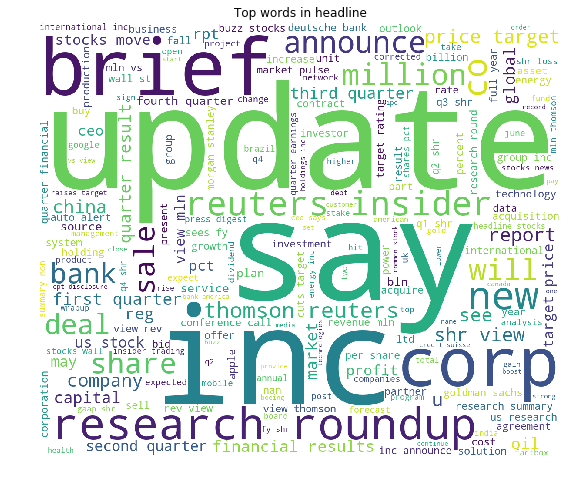

In [39]:
import matplotlib.pyplot as plt

def visualize_by_size(n = 10000):
    text = ' '.join(np.random.choice(list(news_train_df['headline'].str.lower()), n))
    wordcloud = WordCloud(max_font_size=None, stopwords=None, background_color='white',
                          width=1200, height=1000).generate(text)
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud)
    plt.title('Top words in headline')
    plt.axis("off")
    plt.show()
visualize_by_size()